In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf 
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Görselleri ve maskeleri yükleyecek olan fonksiyonları yazıyoruz.

In [3]:
from glob import glob
import cv2
import numpy as np
import os


def prepare_dataset(path1,path2):

    imgs = sorted(glob(os.path.join(path1, "*.png")))
    msks = sorted(glob(os.path.join(path2, "*.png")))


    imlist = []
    masklist = []

    for img in imgs:
      im0 = cv2.imread(img)
      im0 = cv2.resize(im0, (512,512))
      im0 = im0/255.0
      im0 = im0.astype(np.float32)
      #im0 = np.expand_dims(im0, axis=3)

      imlist.append(im0)

    listofimages = np.array(imlist, dtype="float32")

    for msk in msks:
      ma0 = cv2.imread(msk)
      ma0 = cv2.cvtColor(ma0, cv2.COLOR_BGR2GRAY)
      ma0 = cv2.resize(ma0, (512,512))
      ma0 = ma0/255.0
      ma0 = ma0.astype(np.float32)     
      ma0 = np.expand_dims(ma0, axis=-1)

      masklist.append(ma0)

    listofmasks = np.array(masklist, dtype="float32")

    print(f"Görüntülerin shape'i :  {listofimages.shape}")
    print(f"Maskelerin shape'i :  {listofmasks.shape}")

    return listofimages, listofmasks


def splitter(arr1, arr2, split_size):

    train_x, train_y, test_x, test_y = train_test_split(arr1, arr2, test_size=split_size, random_state=42)

    return train_x, train_y, test_x, test_y

# ilk aşamada ram yetersizliğinden dolayı veri1/duzenlenmis_3/ içinden ilk 650 veriyi aldık.

# Verileri önişlemeye aldık ve ardınan eğitim ve test verisi olarak ayırdık.

In [4]:
impath = "/content/drive/MyDrive/segmentasyon_verileri/veriler/veri1/duzenlenmis_3/images"
maskpath = "/content/drive/MyDrive/segmentasyon_verileri/veriler/veri1/duzenlenmis_3/masks"

images, masks = prepare_dataset(impath, maskpath)

train_x, test_x, train_y, test_y = splitter(images, masks, split_size=0.20)

print(f"Train image sayısı : {len(train_x)} - Train maske sayısı : {len(test_x)}")
print(f"Test image sayısı : {len(train_y)} - Test maske sayısı : {len(test_y)}")

Görüntülerin shape'i :  (1133, 512, 512, 3)
Maskelerin shape'i :  (1133, 512, 512, 1)
Train image sayısı : 906 - Train maske sayısı : 227
Test image sayısı : 906 - Test maske sayısı : 227


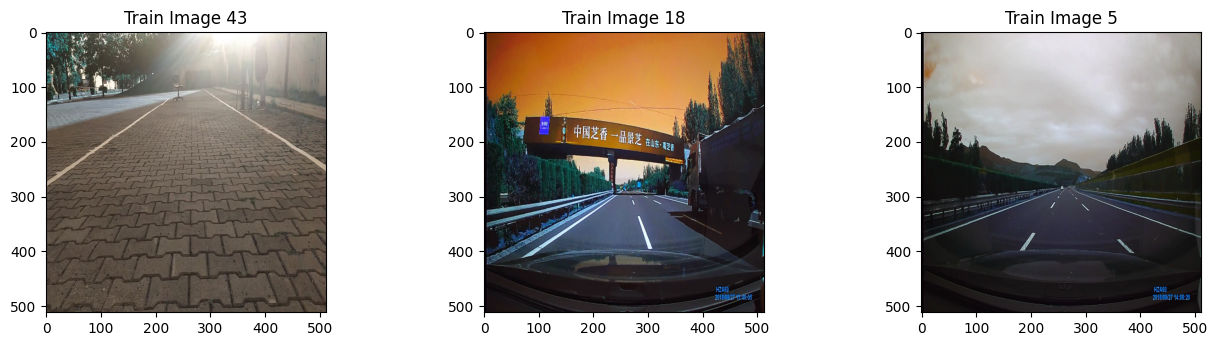

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Train Image 43')
plt.imshow(train_x[28], cmap='gray')
plt.subplot(232)
plt.title('Train Image 18')
plt.imshow(train_x[18], cmap='gray')
plt.subplot(233)
plt.title('Train Image 5')
plt.imshow(train_x[5], cmap='gray')

plt.show()

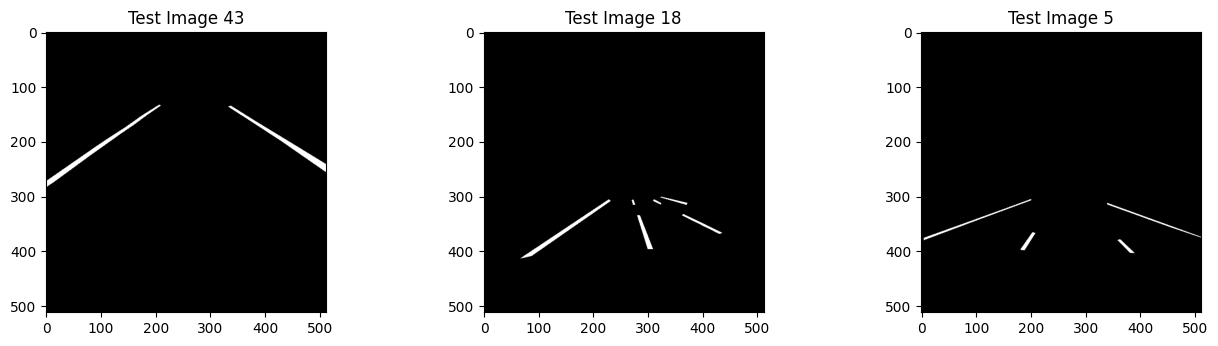

In [6]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Test Image 43')
plt.imshow(train_y[28], cmap='gray')
plt.subplot(232)
plt.title('Test Image 18')
plt.imshow(train_y[18], cmap='gray')
plt.subplot(233)
plt.title('Test Image 5')
plt.imshow(train_y[5], cmap='gray')

plt.show()

In [7]:
from keras import backend as K

smooth = 1e-15

def dice_coef(y_true, y_pred):

    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):

    return 1.0 - dice_coef(y_true, y_pred)

In [8]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model


def conv_block(inputs, num_filters):

    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):

    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)

    return x, p

def decoder_block(inputs, skip_features, num_filters):

    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape):

    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    
    return model

In [9]:
""" Hiperparametreler """
H = 512
W = 512
lr = 1e-4
num_epochs = 20
tarih = "02-04-2023"
count = "1"
model_path = f"/content/drive/MyDrive/segmentasyon_verileri/agirliklar/model_{tarih}_{count}.h5"
print(model_path)

""" Seeding """

np.random.seed(42)
tf.random.set_seed(42)

/content/drive/MyDrive/segmentasyon_verileri/agirliklar/model_02-04-2023_1.h5


In [10]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam

In [ ]:
from keras.models import load_model

model = build_unet((H, W, 3))
model = load_model("/content/drive/MyDrive/segmentasyon_verileri/agirliklar/unet_lane_segmentation_02_04_23.h5",custom_objects={"dice_loss":dice_loss, "dice_coef":dice_coef})
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])
#model.summary()

In [ ]:
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])
#model.summary()

In [ ]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='loss', patience=20, restore_best_weights=False)]

In [ ]:
history = model.fit(
    train_x,
    train_y,
    batch_size = 4,
    epochs=num_epochs,
    callbacks=callbacks,
    verbose=1)

In [ ]:
model.save("/content/drive/MyDrive/segmentasyon_verileri/agirliklar/unet_lane_segmentation_02_04_23_2.h5")

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['dice_coef']
val_Acc = history.history['val_dice_coef']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)

plt.plot(epochs, train_acc, 'b*-', label='Training Accuracy')
plt.plot(epochs, val_Acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
         
plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training Loss') # b*- mavi renkle ilgili bişey
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
import random 

threshold = 0.5
test_img_number = random.randint(0, len(test_x)-1)
test_img = test_x[test_img_number]
ground_truth=test_y[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()